In [1]:
#mean_filename = [p for p in os.listdir(data_pth) if "mean" in p and task in p][0] # mean soma func filename
#mean_img = nib.load(data_pth+mean_filename)

In [1]:
# import packages
from nilearn import image, plotting
import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob
import numpy as np
import nibabel as nib
from spynoza.filtering.nodes import Savgol_filter#, Savgol_filter_confounds
from spynoza.conversion.nodes import Percent_signal_change
from nipype import Node, Function
import nipype.pipeline as pe
import nipype.interfaces.io as nio
from bids.grabbids import BIDSLayout
import pandas as pd

from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show
from nistats.reporting import plot_design_matrix, plot_contrast_matrix

from nistats.first_level_model import FirstLevelModel

#from nipype.interfaces import fsl
#from nipype.interfaces import freesurfer
#from nipype.interfaces.utility import Function, IdentityInterface


In [2]:
# define paths and variables
sub_list = ['5']
ses_list = ['1']
task='soma'

sub_num = str(sub_list[0]).zfill(2)
ses_num = str(ses_list[0]).zfill(2)

data_pth = '/home/neuro/projects/data/derivatives/post_fmriprep/sub-'+sub_num+'/ses-'+ses_num+'/func/' #'/home/neuro/projects/data/derivatives/fmriprep/sub-'+sub_num+'/ses-'+ses_num+'/func/'
event_pth = '/home/neuro/projects/data/sub-'+sub_num+'/ses-'+ses_num+'/func/'
code_pth = '/home/neuro/projects/code/SB_ref_processing/func_proc/'

In [3]:
os.listdir(data_pth)

['sub-05_ses-01_task-soma_run-01_bold_confounds_sg_sd-diff.pdf',
 'sub-05_ses-01_task-soma_run-04_bold_confounds_sg_sd-diff.pdf',
 'sub-05_ses-01_task-soma_run-03_bold_space-T1w_preproc_sg_psc_nuis.nii.gz',
 'sub-05_ses-01_task-soma_run-01_bold_space-T1w_preproc_sg_psc_nuis.nii.gz',
 'sub-05_ses-01_task-soma_run-03_bold_confounds_sg_sd-diff.pdf',
 'sub-05_ses-01_task-soma_run-04_bold_space-T1w_preproc_sg_psc_nuis.nii.gz',
 'sub-05_ses-01_task-soma_run-01_bold_space-T1w_preproc_sg_psc_nuis_correlation_lhand.nii.gz']

In [4]:
# save relevant params used in json file, 
# afterwards just need to call the field of the list/dict
import json
analysis_params = {}
json_info = open(code_pth+'SBref_analysis_params.json','r').read()
analysis_params.update(json.loads(json_info))

In [5]:
# define design matrix etc for all runs of sub

In [6]:
soma_data = [p for p in os.listdir(data_pth) if task in p and "run-0" in p and p.endswith('nuis.nii.gz')]; soma_data.sort() #list of soma func runs, sorted
#soma_data = [p for p in os.listdir(data_pth) if task in p and "run-0" in p and p.endswith('T1w_preproc.nii.gz')]; soma_data.sort() #list of soma func runs, sorted
#soma_confounds = [p for p in os.listdir(data_pth) if task in p and "run-0" in p and p.endswith('bold_confounds.tsv')]; soma_confounds.sort()
soma_events = [p for p in os.listdir(event_pth) if task in p and "run-0" in p and p.endswith('.tsv')]; soma_events.sort() #list of soma event runs, sorted

In [7]:
#soma_confounds

In [8]:
soma_data

['sub-05_ses-01_task-soma_run-01_bold_space-T1w_preproc_sg_psc_nuis.nii.gz',
 'sub-05_ses-01_task-soma_run-03_bold_space-T1w_preproc_sg_psc_nuis.nii.gz',
 'sub-05_ses-01_task-soma_run-04_bold_space-T1w_preproc_sg_psc_nuis.nii.gz']

In [9]:
soma_events

['sub-05_ses-01_task-soma_run-01_events.tsv',
 'sub-05_ses-01_task-soma_run-03_events.tsv',
 'sub-05_ses-01_task-soma_run-04_events.tsv']

In [10]:
# make lists with func data abs path and with events dataframe
events_list = list()
soma_list = list()

for e in np.arange(len(soma_events)):
    events_pd = pd.read_csv(event_pth+soma_events[e],sep = '\t')
    
    new_events = []

    for ev in events_pd.iterrows():
        row = ev[1]   
        if row['trial_type'][0] == 'b': # if both hand/leg then add right and left events with same timings
            new_events.append([row['onset'],row['duration'],'l'+row['trial_type'][1:]])
            new_events.append([row['onset'],row['duration'],'r'+row['trial_type'][1:]])
        else:
            new_events.append([row['onset'],row['duration'],row['trial_type']])
   
    df = pd.DataFrame(new_events, columns=['onset','duration','trial_type'])  #make sure only relevant columns present
    
    events_list.append(df)
    soma_list.append(data_pth+soma_data[e])
    

In [11]:
# # make lists with func data abs path and with events dataframe
# events_list = list()
# soma_list = list()

# for e in np.arange(len(soma_events)):
#     events_pd = pd.read_csv(event_pth+soma_events[e],sep = '\t')
    
#     new_events = []

#     for ev in events_pd.iterrows():
#         row = ev[1]   
#         if row['trial_type'][0] == 'b': # if both hand/leg then add right and left events with same timings
#             new_events.append([row['onset'],row['duration'],'l'+row['trial_type'][1:]])
#             new_events.append([row['onset'],row['duration'],'r'+row['trial_type'][1:]])    
#         new_events.append([row['onset'],row['duration'],row['trial_type']])
   
#     df = pd.DataFrame(new_events, columns=['onset','duration','trial_type'])  #make sure only relevant columns present
    
#     events_list.append(df)
#     soma_list.append(data_pth+soma_data[e])
    

In [12]:
if (sub_num=='01' or sub_num=='03') and ses_num=='01': # exception for some initial subjects' sessions
    TR = 1.5
else:
    TR = analysis_params['TR'] 

In [13]:
fmri_glm = FirstLevelModel(t_r=TR,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='glover',
                           n_jobs=4)

In [14]:
# all_confs = []
# for run_nr in [0,1,2]:
#     confs = pd.read_csv(data_pth+soma_confounds[run_nr], sep='\t', na_values='n/a')
#     all_confs.append(pd.DataFrame(np.nan_to_num(confs), columns=confs.columns))


In [15]:
#fmri_glm = fmri_glm.fit(soma_list, confounds=all_confs,events=events_list)
fmri_glm = fmri_glm.fit(soma_list,events=events_list)

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nistats/first_level_model.py:60: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


In [16]:
design_matrix = fmri_glm.design_matrices_[0]

3


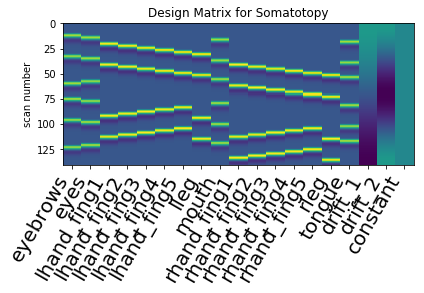

In [17]:
print(len(fmri_glm.design_matrices_))
plot_design_matrix(design_matrix)
plt.title('Design Matrix for Somatotopy')
plt.show()

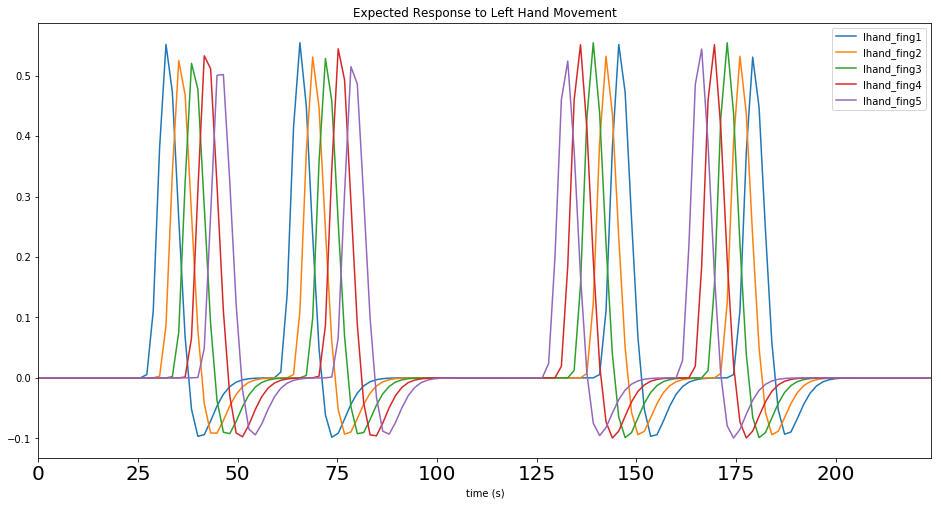

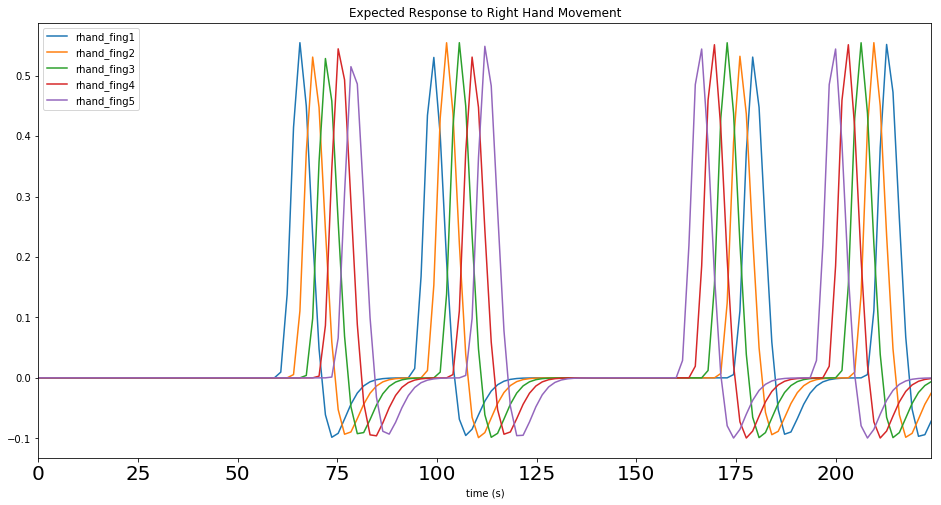

In [18]:
design_matrix[['lhand_fing1', 'lhand_fing2', 'lhand_fing3','lhand_fing4', 'lhand_fing5']].plot(figsize=(16,8))
plt.xlabel('time (s)')
plt.title('Expected Response to Left Hand Movement')
design_matrix[['rhand_fing1', 'rhand_fing2', 'rhand_fing3','rhand_fing4', 'rhand_fing5']].plot(figsize=(16,8))
plt.xlabel('time (s)')
plt.title('Expected Response to Right Hand Movement')

In [19]:
anat_pth = '/home/neuro/projects/data/derivatives/fmriprep/sub-'+sub_num+'/anat/sub-'+sub_num+'_T1w_preproc.nii.gz'
anat_img = image.load_img(anat_pth)

In [19]:
## GENERATE CONTRASTS

In [20]:
# # first generate canonical contrasts
# contrast_matrix = np.eye(design_matrix.shape[1])
# contrasts = dict([(column, contrast_matrix[i])
#                 for i, column in enumerate(design_matrix.columns)])

In [21]:
# f = plt.figure(figsize=(24,4))
# z_map = fmri_glm.compute_contrast(contrasts['bhand_fing1'],
#                                   output_type='stat')
# plot_stat_map(z_map, bg_img=anat_img, threshold=0.5,
#           display_mode='z', cut_coords=3, black_bg=True, figure=f,
#           title='rhand-lhand (Z>3)')
# #z_map.to_filename('zhand_contrast_sub-'+sub_num+'.nii.gz')

In [22]:
# dict([(column, np.eye(design_matrix.shape[1])[i]) for i, column in enumerate(design_matrix.columns)])

In [20]:
#compare left vs right hand

contrast = np.zeros(len(design_matrix.columns)) # array of zeros with len = num predictors

for i in range(len(contrast)):
    if 'rhand' in design_matrix.columns[i]:
        contrast[i] = 1
    elif 'lhand' in design_matrix.columns[i]:
        contrast[i] = -1


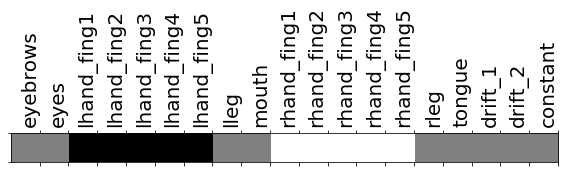

In [21]:
plot_contrast_matrix(contrast, design_matrix=design_matrix)

In [24]:
# compute the estimated effect (has no statistical guarantees)
eff_map = fmri_glm.compute_contrast(contrast,
                                    output_type='effect_size')

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nistats/first_level_model.py:539: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


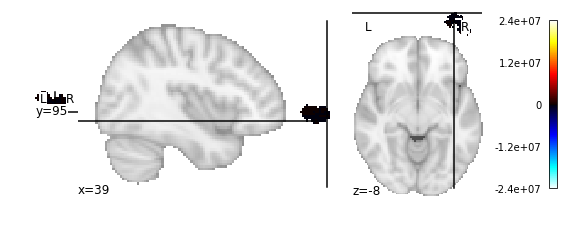

In [25]:
plot_stat_map(eff_map)

In [22]:
z_map = fmri_glm.compute_contrast(contrast,
                                  output_type='stat')

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nistats/first_level_model.py:539: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


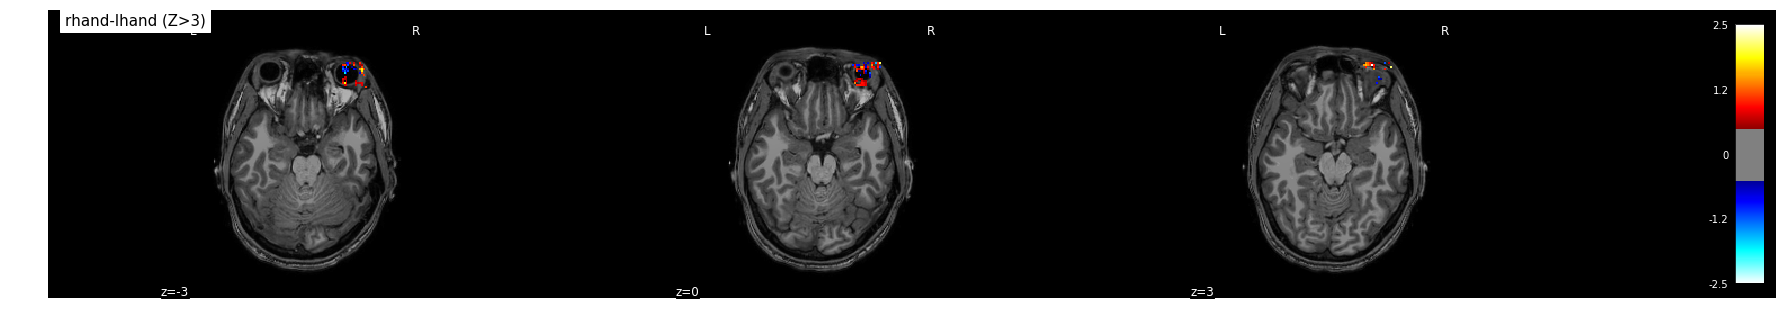

In [23]:
f = plt.figure(figsize=(24,4))
plot_stat_map(z_map, bg_img=anat_img, threshold=0.5,
          display_mode='z', cut_coords=3, black_bg=True, figure=f,
          title='rhand-lhand (Z>3)')
z_map.to_filename('zhand_contrast_sub-'+sub_num+'.nii.gz')

In [27]:
fmri_glm.design_matrices_[0].columns

Index(['eyebrows', 'eyes', 'lhand_fing1', 'lhand_fing2', 'lhand_fing3',
       'lhand_fing4', 'lhand_fing5', 'lleg', 'mouth', 'rhand_fing1',
       'rhand_fing2', 'rhand_fing3', 'rhand_fing4', 'rhand_fing5', 'rleg',
       'tongue', 'drift_1', 'drift_2', 'constant'],
      dtype='object')

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nistats/first_level_model.py:539: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


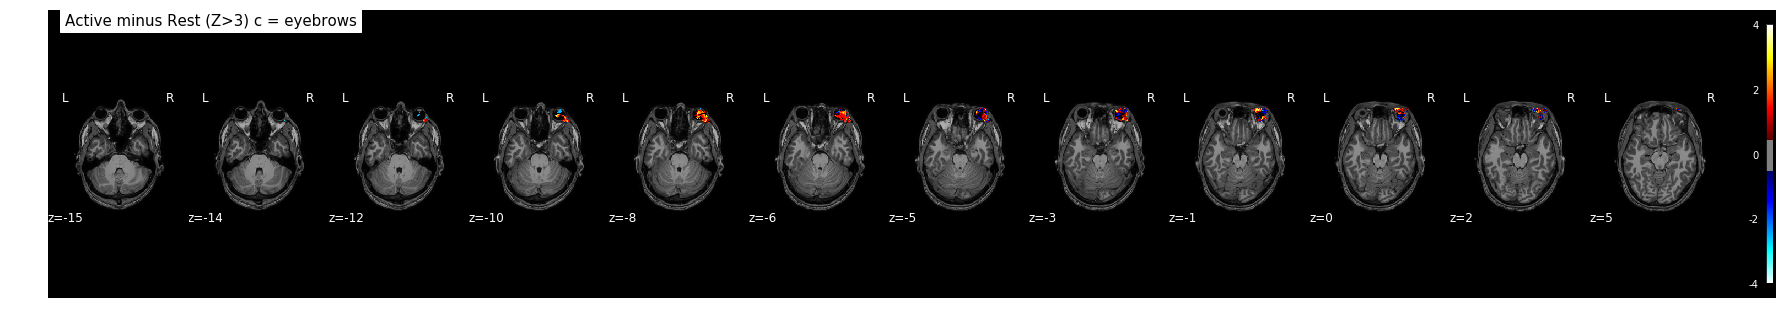

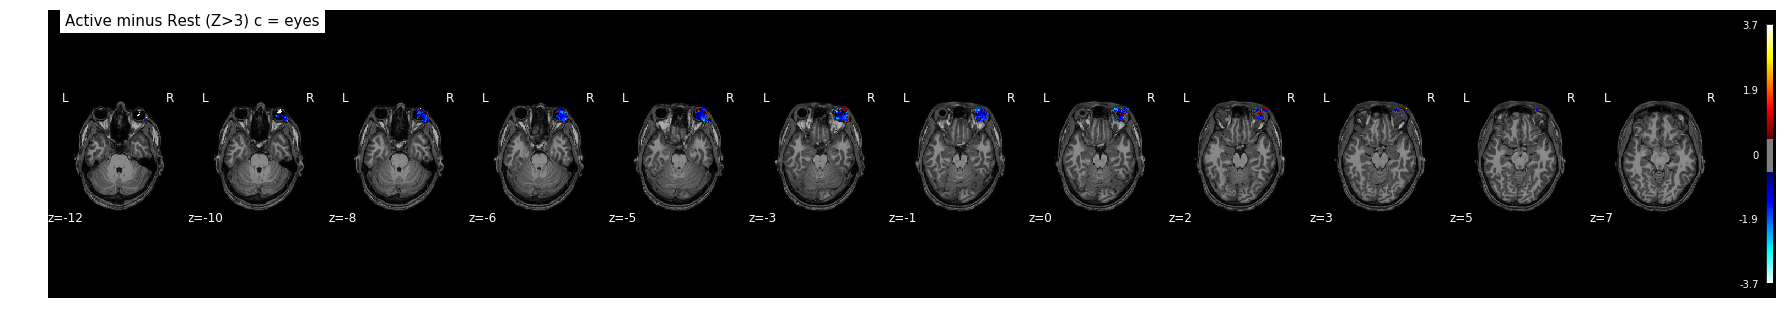

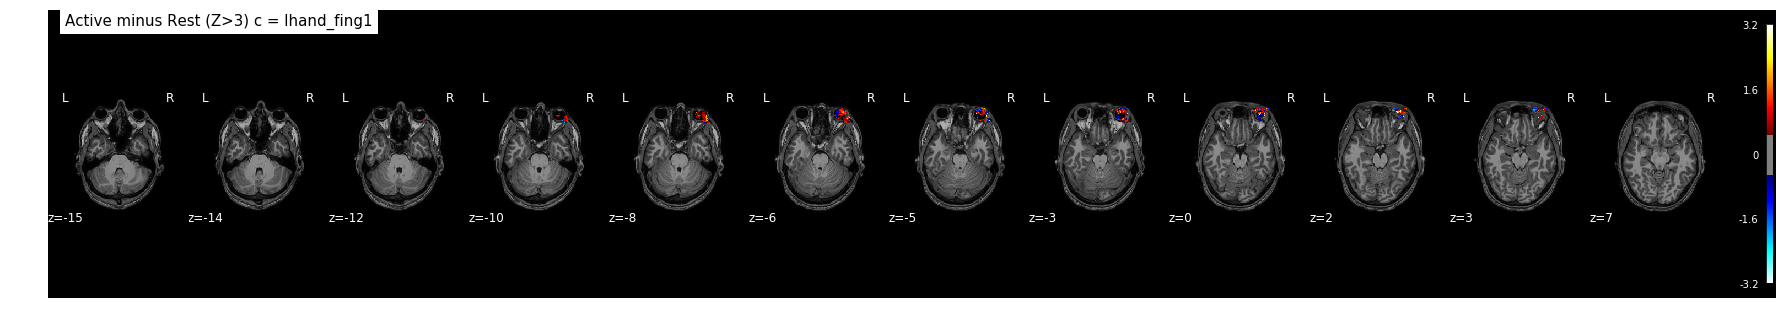

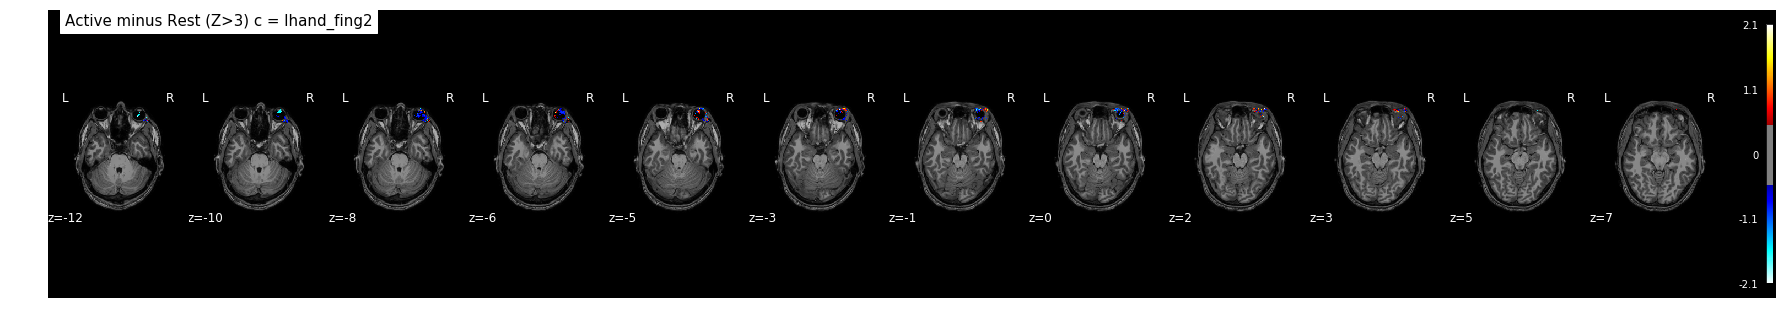

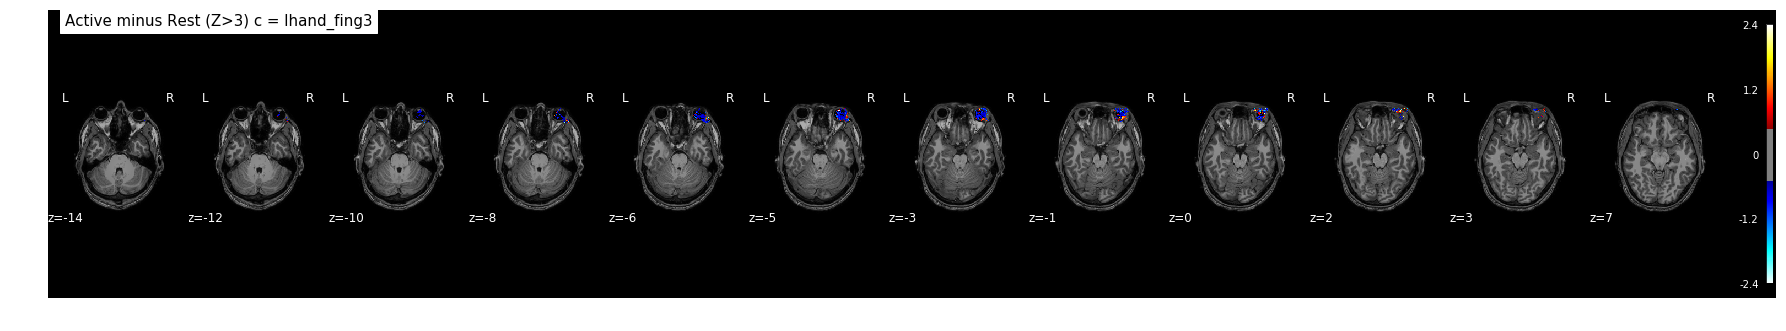

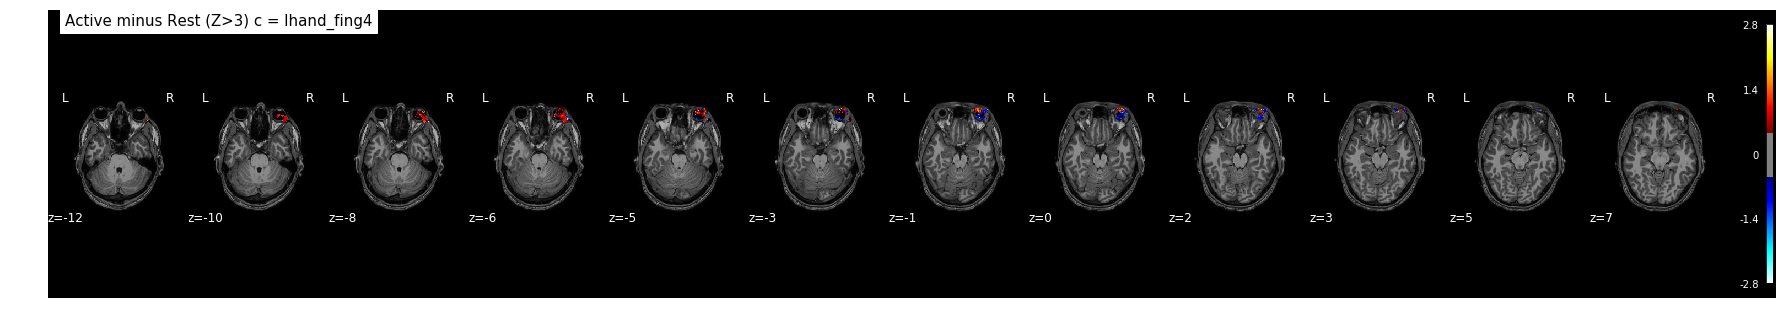

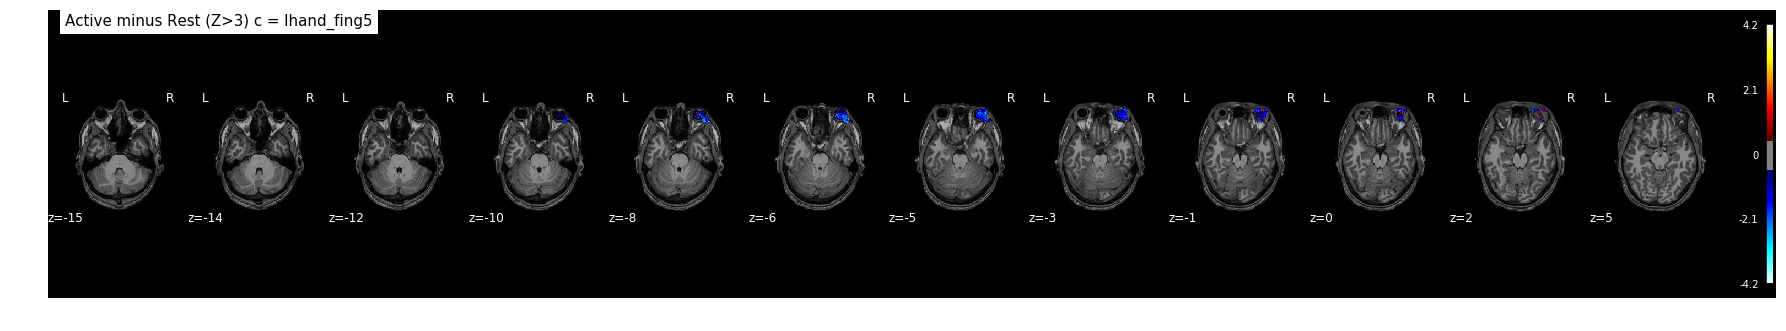

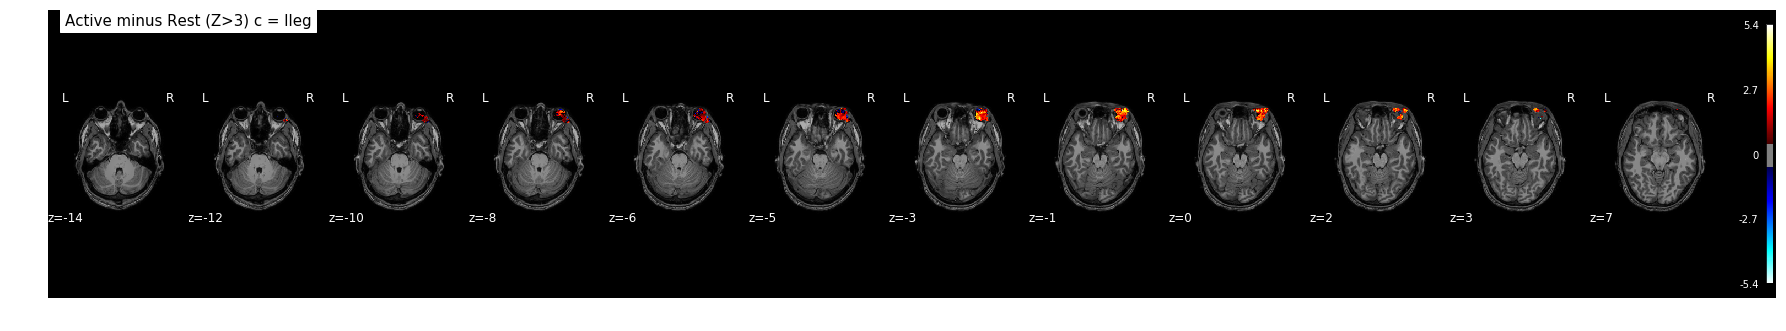

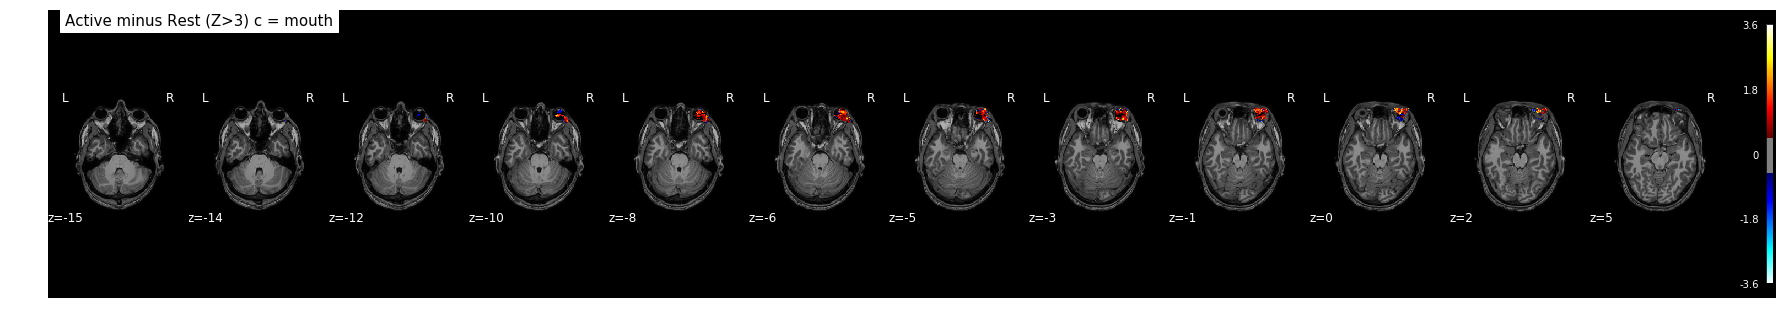

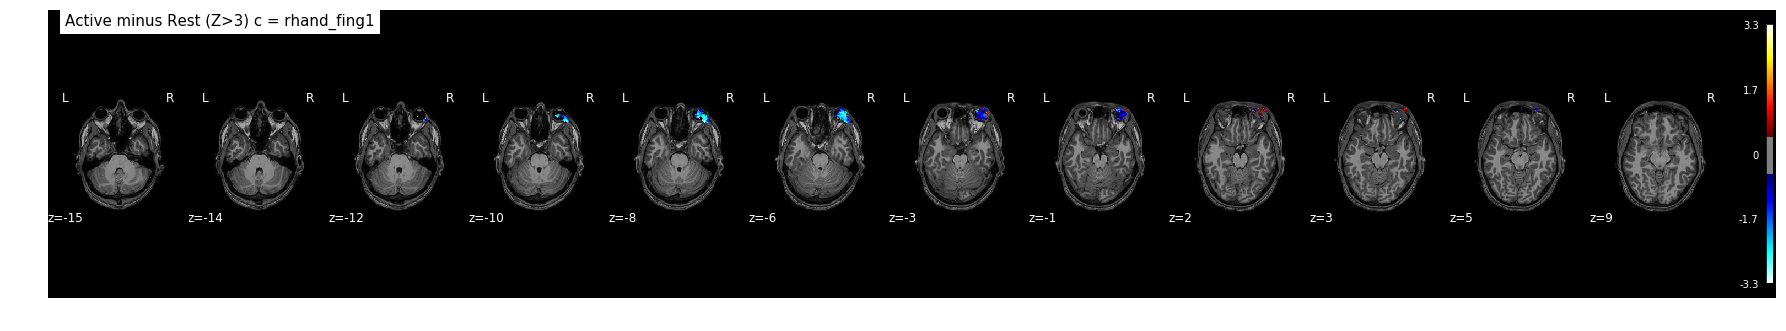

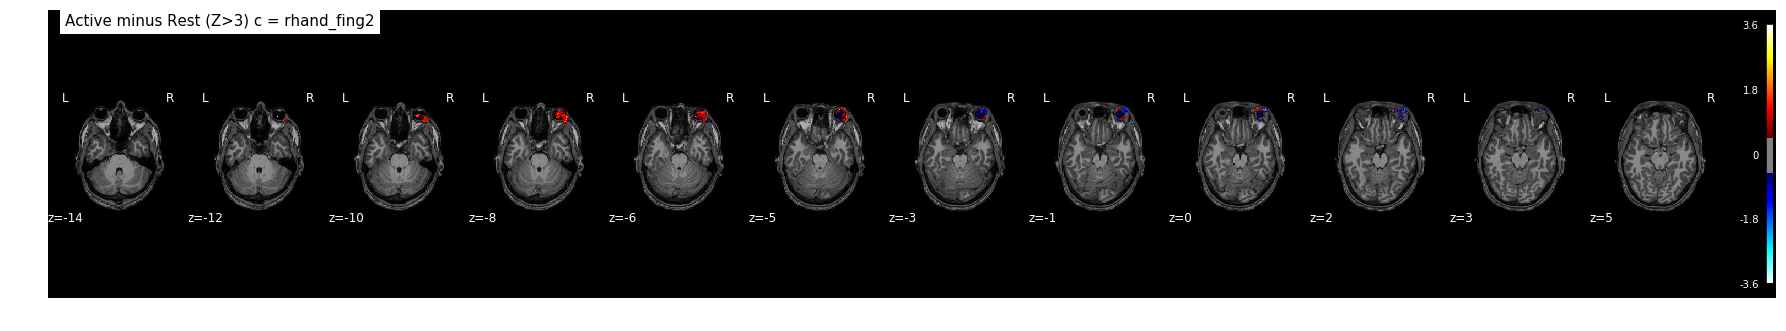

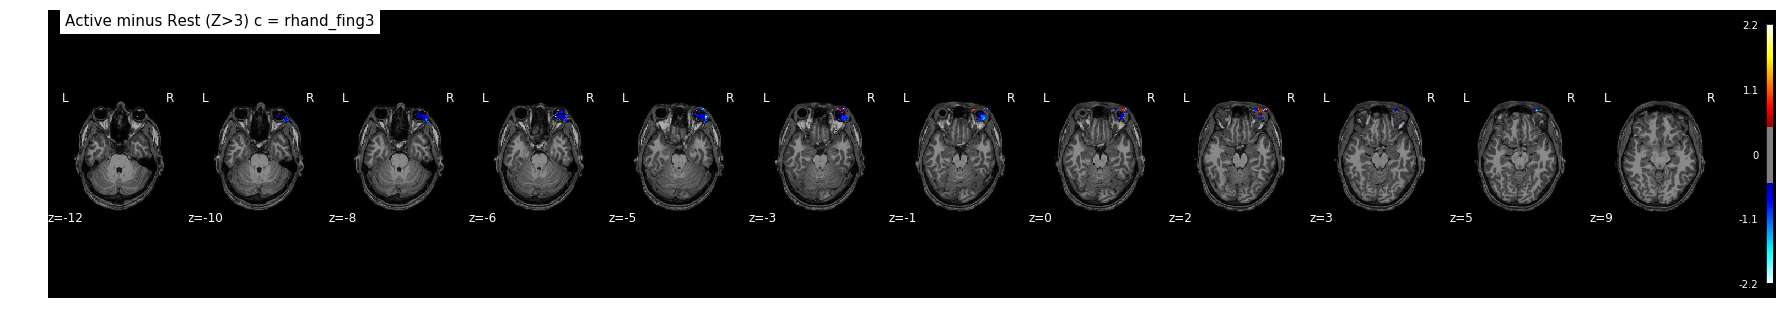

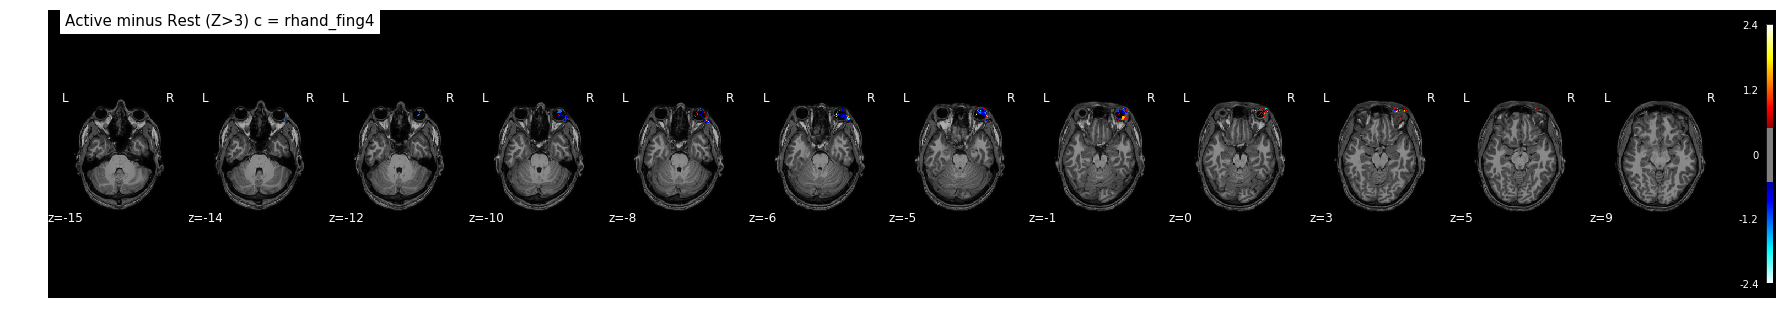

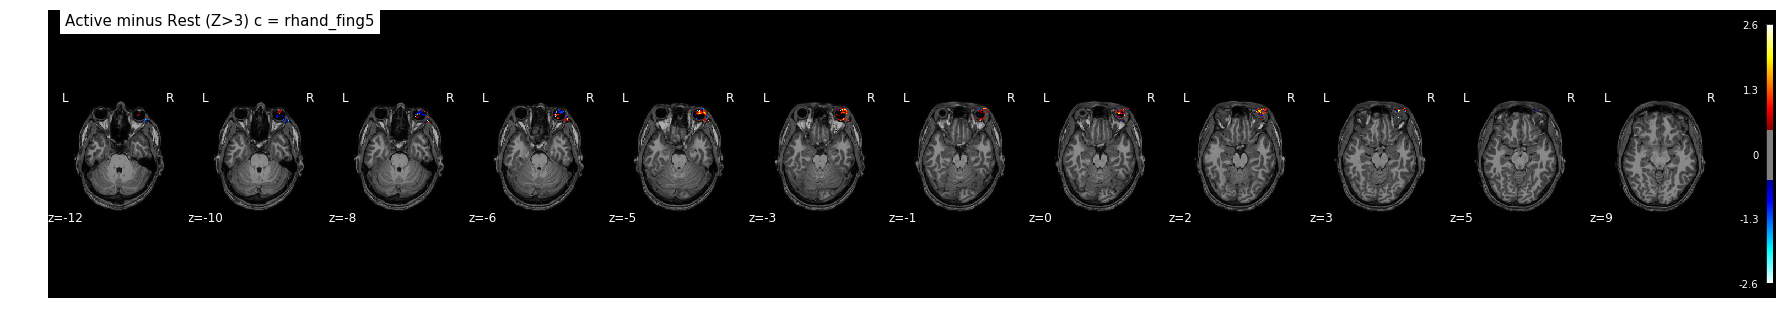

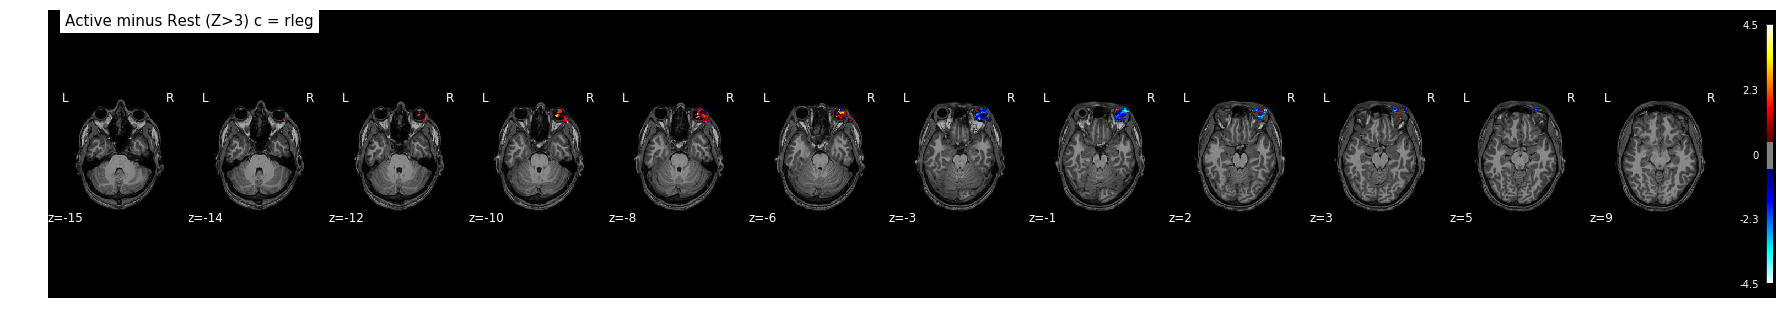

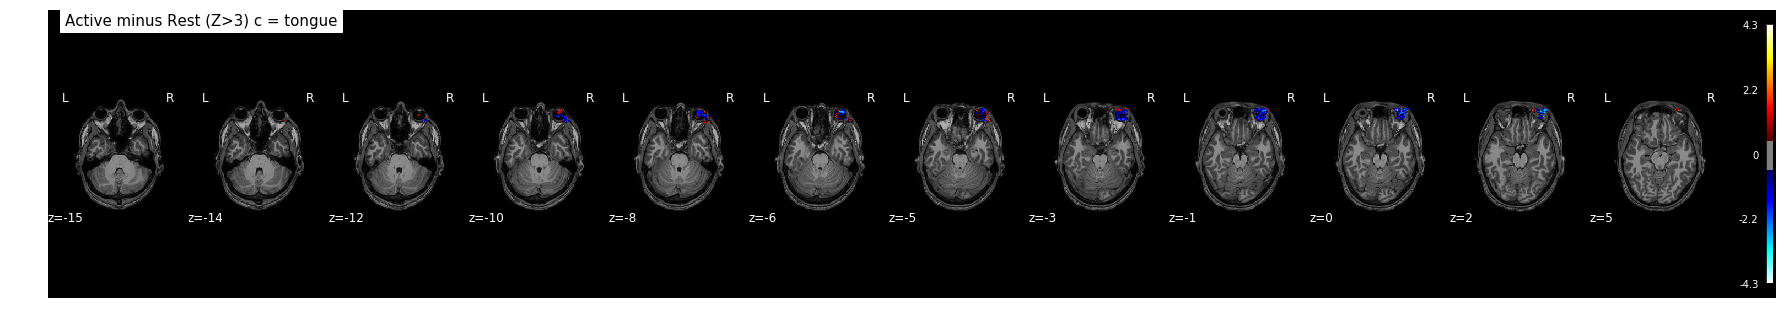

In [29]:
for i, c in enumerate(fmri_glm.design_matrices_[0].columns[:-3]):
    f = plt.figure(figsize=(24,4))
    z_map = fmri_glm.compute_contrast(np.eye(len(fmri_glm.design_matrices_[0].columns))[:-3][i],
                                    output_type='stat')
    plot_stat_map(z_map, bg_img=anat_img, threshold=0.5,
              display_mode='z', cut_coords=12, black_bg=True, figure=f,
              title='Active minus Rest (Z>3) c = {c}'.format(c=fmri_glm.design_matrices_[0].columns[i]))

In [30]:
FirstLevelModel?

Init signature: FirstLevelModel(t_r=None, slice_time_ref=0.0, hrf_model='glover', drift_model='cosine', period_cut=128, drift_order=1, fir_delays=[0], min_onset=-24, mask=None, target_affine=None, target_shape=None, smoothing_fwhm=None, memory=Memory(cachedir=None), memory_level=1, standardize=False, signal_scaling=0, noise_model='ar1', verbose=0, n_jobs=1, minimize_memory=True, subject_label=None)
Docstring:     
Implementation of the General Linear Model for single session fMRI data

Parameters
----------
t_r : float
    This parameter indicates repetition times of the experimental runs.
    In seconds. It is necessary to correctly consider times in the design
    matrix. This parameter is also passed to nilearn.signal.clean.
    Please see the related documentation for details.

slice_time_ref : float, optional (default 0.)
    This parameter indicates the time of the reference slice used in the
    slice timing preprocessing step of the experimental runs. It is
    expressed as a p